In [1]:
import re
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, GRU, concatenate
from keras import metrics
from keras import backend as K
from keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# Custom library for the project
import sys
sys.path.insert(0, '../../src')
import harmoutil

%matplotlib inline

/home/maxime/.local/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# # Remove when done with kernel
import importlib
importlib.reload(harmoutil)

<module 'harmoutil' from '../../src/harmoutil.py'>

In [3]:
# Load data
raw_data = harmoutil.load_pickled_data("../../data/refined_data.pkl") # lists of (chord label, melody seqs) by sections
augmented_data = harmoutil.transpose_and_augment_data(raw_data)
data = [harmoutil.to_sevenths(section) for section in augmented_data]
data = [harmoutil.melody_to_octave_range(section) for section in data]

In [4]:
# Isolate relevant data
def get_notes_by_chord(beats):
    return [note for beat in beats for note in beat]

def get_chords_by_section(section):
    return [chord_info[0] for chord_info in section]

# def check_if_augmented_major(section):
#     section_chords = get_chords_by_section(section)
#     for ch in section_chords:
#         if "+j7" in ch:
#             return True
#     return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
# data = [section for section in data if not check_if_augmented_major(section)]
# print("---Remove sections with augmented major chord---")
# print("Number of sections: {}\n".format(len(data)))

chords_by_sections_bf_augmaj7 = [get_chords_by_section(section) for section in data]
chords = [chord_info[0] for section in data for chord_info in section]
unique_chords = sorted(list(set(chords)))

notes_by_chords_bf_augmaj7 = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
notes = [note for chord_notes in notes_by_chords_bf_augmaj7 for note in chord_notes]
unique_notes = sorted(list(set(notes)))

# print(sum([len(section) for section in chords_by_sections]))
# print("Number of sections: {} | Sample section chords: {}".format(len(chords_by_sections), chords_by_sections[0]))
print("Number of chords: {} | Sample chord: {}".format(len(chords), chords[0]))
# print("Number of melodies {} | Sample melody: {}".format(len(notes_by_chords), notes_by_chords[0]))
print("Number of melody notes in the data: {} | Sample melody note: {}".format(len(notes), notes[0]))
print("Unique notes: {}".format(unique_notes))
print("Unique notes: {}".format(unique_chords))

Number of chords: 334344 | Sample chord: E6
Number of melody notes in the data: 2209944 | Sample melody note: 4
Unique notes: [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Unique notes: ['A', 'A+', 'A+7', 'A+j7', 'A-', 'A-6', 'A-7', 'A-j7', 'A6', 'A7', 'Ab', 'Ab+', 'Ab+7', 'Ab+j7', 'Ab-', 'Ab-6', 'Ab-7', 'Ab-j7', 'Ab6', 'Ab7', 'Abj7', 'Abm7b5', 'Abo', 'Abo7', 'Absus', 'Absus7', 'Aj7', 'Am7b5', 'Ao', 'Ao7', 'Asus', 'Asus7', 'B', 'B+', 'B+7', 'B+j7', 'B-', 'B-6', 'B-7', 'B-j7', 'B6', 'B7', 'Bb', 'Bb+', 'Bb+7', 'Bb+j7', 'Bb-', 'Bb-6', 'Bb-7', 'Bb-j7', 'Bb6', 'Bb7', 'Bbj7', 'Bbm7b5', 'Bbo', 'Bbo7', 'Bbsus', 'Bbsus7', 'Bj7', 'Bm7b5', 'Bo', 'Bo7', 'Bsus', 'Bsus7', 'C', 'C+', 'C+7', 'C+j7', 'C-', 'C-6', 'C-7', 'C-j7', 'C6', 'C7', 'Cj7', 'Cm7b5', 'Co', 'Co7', 'Csus', 'Csus7', 'D', 'D+', 'D+7', 'D+j7', 'D-', 'D-6', 'D-7', 'D-j7', 'D6', 'D7', 'Db', 'Db+', 'Db+7', 'Db+j7', 'Db-', 'Db-6', 'Db-7', 'Db-j7', 'Db6', 'Db7', 'Dbj7', 'Dbm7b5', 'Dbo', 'Dbo7', 'Dbsus', 'Dbsus7', 'Dj7', 'Dm7b5', 'Do', 'Do7', '

In [5]:
# Create categorical data mappings
note_to_int = dict([(c, i) for i, c in enumerate(unique_notes[1:])])
note_to_int[-1] = len(note_to_int)
note_to_int['<pad>'] = len(note_to_int)

int_to_note = dict([(k, v) for v, k in note_to_int.items()])

chord_to_int = dict([(c, i) for i, c in enumerate(unique_chords)])
chord_to_int['<bos>'] = len(chord_to_int)
chord_to_int['<eos>'] = len(chord_to_int)

int_to_chord = dict([(k, v) for v, k in chord_to_int.items()])

print("Melody note to integer mapping:\n {}\n".format(note_to_int))
print("Integer to melody note mapping:\n {}\n".format(int_to_note))
print("Chord label to integer mapping:\n {}\n".format(chord_to_int))
print("Integer to chord label mapping:\n {}\n".format(int_to_chord))

Melody note to integer mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, -1: 12, '<pad>': 13}

Integer to melody note mapping:
 {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: -1, 13: '<pad>'}

Chord label to integer mapping:
 {'E-6': 117, 'Ab-6': 15, 'A-': 4, 'Absus7': 25, 'Fo7': 157, 'G+': 161, 'Db-': 94, 'Bb-j7': 49, 'Dbsus7': 105, 'F7': 153, 'Bm7b5': 59, 'Gbm7b5': 181, '<eos>': 194, 'Bb-6': 47, 'Bsus7': 63, 'C6': 72, 'Bbm7b5': 53, 'G6': 168, 'Bb': 42, 'Fsus7': 159, 'E7': 121, 'Bsus': 62, 'Gbo': 182, 'A+j7': 3, 'Ebj7': 132, 'Ao': 28, 'C+7': 66, 'Gbsus7': 185, 'E+': 113, 'F-6': 149, 'Ebm7b5': 133, 'C-j7': 71, 'Ab6': 18, 'Eb-j7': 129, 'Bb6': 50, 'Fm7b5': 155, 'Ebsus7': 137, 'Eb+': 123, 'Gsus': 190, 'Eb6': 130, 'D': 80, 'Ab': 10, 'C-': 68, 'A+7': 2, 'Ab-j7': 17, 'Db-7': 96, 'B+': 33, 'Gbj7': 180, 'Em7b5': 139, 'G+7': 162, 'Abj7': 20, 'Bbo7': 55, 'Go': 188, 'Gj7': 186, 'G7': 169, 'Bbj7': 52, 'Fo': 156, 'F-7': 150, 'C7

In [6]:
# Define numerical variables

n_samples = len(chords)
n_chords = len(chord_to_int)
n_notes = len(note_to_int)
max_mel_len = max([len(mel) for mel in notes_by_chords_bf_augmaj7])
chord_context_len = 7

# print("Total number of samples: {}".format(n_samples))
print("Total number of samples: {}".format(n_samples))
print("Number of distinct melody notes: {}".format(n_notes))
print("Number of distinct chord labels: {}".format(n_chords))
print("Maximum length of melody sequences for one chord: {}".format(max_mel_len))
print("Number of past chords given as input: {}".format(chord_context_len))

Total number of samples: 334344
Number of distinct melody notes: 14
Number of distinct chord labels: 195
Maximum length of melody sequences for one chord: 135
Number of past chords given as input: 7


In [7]:
mel_by_sections = [mel for section in data for ch, mel in section]
print(mel_by_sections[0])

[[4], [4]]


In [8]:
# Prepare tensor data


def check_if_augmented_major(section):
    section_chords = get_chords_by_section(section)
    for ch in section_chords:
        if "+j7" in ch:
            return True
    return False


# Remove sections that involve augmented major chords (since not enough data to even allow StratifiedShuffleSplit)
data = [section for section in data if not check_if_augmented_major(section)]
print("---Remove sections with augmented major chord---")
print("Number of sections: {}\n".format(len(data)))

chords_by_sections = [get_chords_by_section(section) for section in data]
# chords = [chord_info[0] for section in data for chord_info in section]
# unique_chords = sorted(list(set(chords)))

notes_by_chords = [get_notes_by_chord(chord_info[1]) for section in data for chord_info in section]
# notes = [note for chord_notes in notes_by_chords for note in chord_notes]
# unique_notes = sorted(list(set(notes)))



def pad_melody(melody, max_len):
    return melody + (max_len-len(melody))*['<pad>']

def build_input_chord_sequences(chord_seq, context_len):
    padded_sequence = context_len*['<bos>'] + chord_seq
    formatted_sequences = [padded_sequence[i:i+context_len+1] for i in range(len(chord_seq))]
    return formatted_sequences

# Melody
input_melody_data = [pad_melody(melody, max_mel_len) for melody in notes_by_chords]
print("Sample input melody sequence: {}\n".format(input_melody_data[5]))

# Chords
formatted_chords_data = []
for section_chords in chords_by_sections:
    formatted_chords_data += build_input_chord_sequences(section_chords, chord_context_len)
    
input_chords_data = [ch[:-1] for ch in formatted_chords_data]
target_chords_data = [ch[-1] for ch in formatted_chords_data]
print("Sample input chord sequence: {}\n".format(input_chords_data[5]))
print("Sample target chord: {}\n".format(target_chords_data[5]))

print("Input melody: {}, Input chords: {}, Target chords: {}".format(len(input_melody_data), len(input_chords_data), len(target_chords_data)))

---Remove sections with augmented major chord---
Number of sections: 28836

Sample input melody sequence: [8, 3, 6, '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<

In [10]:
# Load embedding vectors

num_dim = 8
num_ch = 192
num_notes = 12

# Define embedding training model and load weights
input_layer = Input(shape=(num_ch,)) 
embeddings_layer = Dense(num_dim, activation='linear', name="embeddings")(input_layer)
root_output_layer = Dense(num_notes, activation='softmax')(embeddings_layer)
interval_output_layer = Dense(num_notes, activation='sigmoid')(embeddings_layer)
pitch_output_layer = Dense(num_notes, activation='sigmoid')(embeddings_layer)
melody_output_layer = Dense(num_notes, activation='relu')(embeddings_layer)
embeddings_model = Model(input_layer, [root_output_layer, interval_output_layer, pitch_output_layer, melody_output_layer])

embeddings_model.load_weights("../Skipgram & WJD/weights/combined_weights_dim8.h5")

X_chords_embeddings = embeddings_model.layers[1].get_weights()[0]
print(X_chords_embeddings.shape)


(192, 8)


In [11]:
# Build tensors

n_dimensions = X_chords_embeddings.shape[1]
print("Size of embedding vector for each chord: {}".format(n_dimensions))

X_melody = np.zeros((n_samples, max_mel_len, n_notes), dtype='float32')
X_chords = np.zeros((n_samples, chord_context_len, n_dimensions), dtype='float32')
Y_chord = np.zeros((n_samples, n_chords), dtype='float32')

for i, (input_mel, input_ch, target_ch) in enumerate(zip(input_melody_data, input_chords_data, target_chords_data)):
    Y_chord[i, chord_to_int[target_ch]] = 1
    for j, chord in enumerate(input_ch):
#         X_chords[i, j, chord_to_int[chord]] = 1
        chord_index = chord_to_int[chord]
        if (chord_index < num_ch):
            X_chords[i, j, :] = X_chords_embeddings[chord_index, :]
    
    for j, note in enumerate(input_mel):
        X_melody[i, j, note_to_int[note]] = 1

Size of embedding vector for each chord: 8


In [12]:
print(X_melody.shape)
print(X_chords.shape)
print(Y_chord.shape)

(334344, 135, 14)
(334344, 7, 8)
(334344, 195)


In [13]:
# Split dataset into 80%-10%-10% train-valid-test sets
seed = 0

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)

for train_index, aux_index in sss.split(X_chords, Y_chord):
    X_melody_train, X_melody_aux = X_melody[train_index], X_melody[aux_index]
    X_chords_train, X_chords_aux = X_chords[train_index], X_chords[aux_index]
    Y_chord_train, Y_chord_aux = Y_chord[train_index], Y_chord[aux_index]
    
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=seed)

for valid_index, test_index in sss.split(X_chords_aux, Y_chord_aux):
    X_melody_valid, X_melody_test = X_melody[valid_index], X_melody[test_index]
    X_chords_valid, X_chords_test = X_chords[valid_index], X_chords[test_index]
    Y_chord_valid, Y_chord_test = Y_chord[valid_index], Y_chord[test_index]

In [14]:
# Define neual net architecture

latent_dim = 128

melody_input = Input(shape=(max_mel_len, n_notes))
melody_gru1 = GRU(latent_dim, return_sequences=True)(melody_input)
melody_gru2 = GRU(latent_dim)(melody_gru1)

chords_input = Input(shape=(chord_context_len, n_dimensions))
chords_gru1 = GRU(latent_dim, return_sequences=True)(chords_input)
chords_gru2 = GRU(latent_dim)(chords_gru1)

concat = concatenate([melody_gru2, chords_gru2])

chord_dense1 = Dense(latent_dim, activation='relu')(concat)
chord_dense2 = Dense(n_chords, activation='softmax')(chord_dense1)

model = Model([melody_input, chords_input], chord_dense2)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 135, 14)       0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 7, 8)          0                                            
____________________________________________________________________________________________________
gru_1 (GRU)                      (None, 135, 128)      54912       input_3[0][0]                    
____________________________________________________________________________________________________
gru_3 (GRU)                      (None, 7, 128

In [15]:
# Introduce Best-Performance callbacks
# es = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
filepath = "models/embeddings8-Mel2-Cho2-FC2_150ep.h5"
bp = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [16]:
# Train model
batch_size = 256
epochs = 150

history = model.fit([X_melody_train, X_chords_train], Y_chord_train, epochs=epochs, validation_data=([X_melody_valid, X_chords_valid], Y_chord_valid), batch_size=batch_size, callbacks=[bp])

Train on 267475 samples, validate on 33434 samples
Epoch 1/150
267475/267475 [==============================] - 931s - loss: 2.8239 - acc: 0.3585 - val_loss: 2.4328 - val_acc: 0.4323
Epoch 2/150
267475/267475 [==============================] - 931s - loss: 2.1908 - acc: 0.4799 - val_loss: 2.1596 - val_acc: 0.4988
Epoch 3/150
267475/267475 [==============================] - 931s - loss: 1.9308 - acc: 0.5376 - val_loss: 2.0067 - val_acc: 0.5346
Epoch 4/150
267475/267475 [==============================] - 937s - loss: 1.7469 - acc: 0.5798 - val_loss: 1.8938 - val_acc: 0.5669
Epoch 5/150
267475/267475 [==============================] - 941s - loss: 1.6086 - acc: 0.6123 - val_loss: 1.8107 - val_acc: 0.5841
Epoch 6/150
267475/267475 [==============================] - 940s - loss: 1.5003 - acc: 0.6368 - val_loss: 1.7615 - val_acc: 0.5954
Epoch 7/150
267475/267475 [==============================] - 940s - loss: 1.4154 - acc: 0.6556 - val_loss: 1.7024 - val_acc: 0.6140
Epoch 8/150
267475/267475

267475/267475 [==============================] - 928s - loss: 0.8829 - acc: 0.7587 - val_loss: 1.3520 - val_acc: 0.7008
Epoch 26/150
267475/267475 [==============================] - 928s - loss: 0.8644 - acc: 0.7638 - val_loss: 1.3390 - val_acc: 0.7050
Epoch 27/150
267475/267475 [==============================] - 933s - loss: 0.8464 - acc: 0.7676 - val_loss: 1.3358 - val_acc: 0.7079
Epoch 28/150
267475/267475 [==============================] - 937s - loss: 0.8292 - acc: 0.7719 - val_loss: 1.3308 - val_acc: 0.7122
Epoch 29/150
267475/267475 [==============================] - 937s - loss: 0.8133 - acc: 0.7752 - val_loss: 1.3159 - val_acc: 0.7181
Epoch 30/150
267475/267475 [==============================] - 936s - loss: 0.8021 - acc: 0.7780 - val_loss: 1.3151 - val_acc: 0.7183
Epoch 31/150
267475/267475 [==============================] - 930s - loss: 0.7806 - acc: 0.7836 - val_loss: 1.3271 - val_acc: 0.7128
Epoch 32/150
267475/267475 [==============================] - 936s - loss: 0.7697 

267475/267475 [==============================] - 944s - loss: 0.6815 - acc: 0.8056 - val_loss: 1.3915 - val_acc: 0.7138
Epoch 55/150
267475/267475 [==============================] - 941s - loss: 0.6848 - acc: 0.8050 - val_loss: 1.3350 - val_acc: 0.7299
Epoch 56/150
267475/267475 [==============================] - 942s - loss: 0.6631 - acc: 0.8102 - val_loss: 1.3382 - val_acc: 0.7301
Epoch 57/150
267475/267475 [==============================] - 942s - loss: 0.6736 - acc: 0.8075 - val_loss: 1.3504 - val_acc: 0.7252
Epoch 58/150
267475/267475 [==============================] - 951s - loss: 0.6687 - acc: 0.8086 - val_loss: 1.3476 - val_acc: 0.7271
Epoch 59/150
267475/267475 [==============================] - 953s - loss: 0.6617 - acc: 0.8100 - val_loss: 1.3384 - val_acc: 0.7324
Epoch 60/150
267475/267475 [==============================] - 951s - loss: 0.6533 - acc: 0.8120 - val_loss: 1.3403 - val_acc: 0.7327
Epoch 61/150
267475/267475 [==============================] - 952s - loss: 0.6463 

267475/267475 [==============================] - 930s - loss: 0.5696 - acc: 0.8342 - val_loss: 1.3617 - val_acc: 0.7449
Epoch 84/150
267475/267475 [==============================] - 930s - loss: 0.5313 - acc: 0.8462 - val_loss: 1.3863 - val_acc: 0.7405
Epoch 85/150
267475/267475 [==============================] - 926s - loss: 0.5418 - acc: 0.8415 - val_loss: 1.3737 - val_acc: 0.7442
Epoch 86/150
267475/267475 [==============================] - 929s - loss: 0.5272 - acc: 0.8462 - val_loss: 1.3779 - val_acc: 0.7428
Epoch 87/150
267475/267475 [==============================] - 930s - loss: 0.5394 - acc: 0.8432 - val_loss: 1.4049 - val_acc: 0.7354
Epoch 88/150
267475/267475 [==============================] - 930s - loss: 0.5245 - acc: 0.8470 - val_loss: 1.3875 - val_acc: 0.7450
Epoch 89/150
267475/267475 [==============================] - 934s - loss: 0.5132 - acc: 0.8502 - val_loss: 1.3823 - val_acc: 0.7463
Epoch 90/150
267475/267475 [==============================] - 933s - loss: 0.5280 

267475/267475 [==============================] - 938s - loss: 0.4425 - acc: 0.8687 - val_loss: 1.4493 - val_acc: 0.7518
Epoch 114/150
267475/267475 [==============================] - 937s - loss: 0.4301 - acc: 0.8725 - val_loss: 1.4625 - val_acc: 0.7523
Epoch 115/150
267475/267475 [==============================] - 936s - loss: 0.4384 - acc: 0.8700 - val_loss: 1.4692 - val_acc: 0.7513
Epoch 116/150
267475/267475 [==============================] - 933s - loss: 0.4478 - acc: 0.8671 - val_loss: 1.4928 - val_acc: 0.7389
Epoch 117/150
267475/267475 [==============================] - 934s - loss: 0.4463 - acc: 0.8668 - val_loss: 1.4609 - val_acc: 0.7516
Epoch 118/150
267475/267475 [==============================] - 934s - loss: 0.4097 - acc: 0.8786 - val_loss: 1.4582 - val_acc: 0.7570
Epoch 119/150
267475/267475 [==============================] - 940s - loss: 0.4428 - acc: 0.8687 - val_loss: 1.4507 - val_acc: 0.7544
Epoch 120/150
267475/267475 [==============================] - 937s - loss: 

267475/267475 [==============================] - 934s - loss: 0.3780 - acc: 0.8862 - val_loss: 1.4853 - val_acc: 0.7590
Epoch 145/150
267475/267475 [==============================] - 934s - loss: 0.3682 - acc: 0.8893 - val_loss: 1.4932 - val_acc: 0.7592
Epoch 146/150
267475/267475 [==============================] - 930s - loss: 0.3808 - acc: 0.8857 - val_loss: 1.4997 - val_acc: 0.7588
Epoch 147/150
267475/267475 [==============================] - 927s - loss: 0.3837 - acc: 0.8846 - val_loss: 1.4874 - val_acc: 0.7628
Epoch 148/150
267475/267475 [==============================] - 927s - loss: 0.3697 - acc: 0.8884 - val_loss: 1.5212 - val_acc: 0.7581
Epoch 149/150
267475/267475 [==============================] - 934s - loss: 0.4377 - acc: 0.8705 - val_loss: 1.5242 - val_acc: 0.7475
Epoch 150/150
267475/267475 [==============================] - 933s - loss: 0.3892 - acc: 0.8830 - val_loss: 1.4937 - val_acc: 0.7600


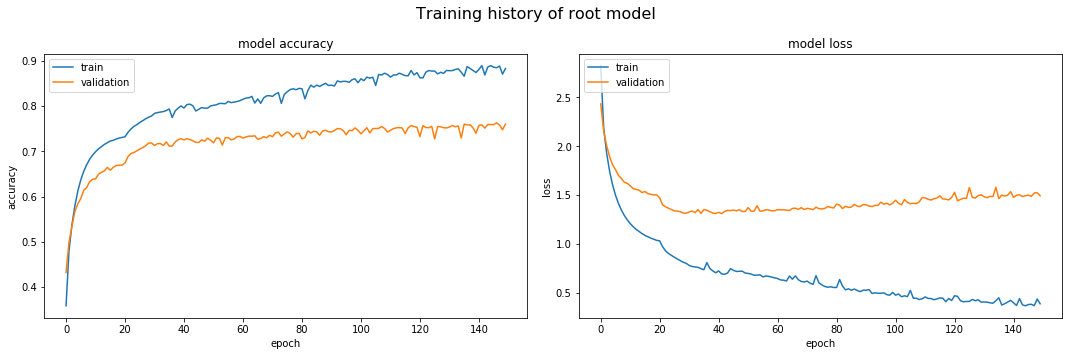

In [17]:
# Visualize model learning
plt.clf()

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# plt.show()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.tight_layout()
plt.suptitle("Training history of root model", fontsize=16)
plt.subplots_adjust(top=0.85)
plt.show()

In [18]:
# Load best performance model
best_model = load_model("models/embeddings8-Mel2-Cho2-FC2_150ep.h5")

In [19]:
print(X_melody_test.shape)
print(X_chords_test.shape)

(33435, 135, 14)
(33435, 7, 8)


In [20]:
# Evaluate predictions in terms of labels

# Predict chords from each test sample melody
Y_chord_pred = model.predict([X_melody_test, X_chords_test])

# Compute accuracy and kappa score 
print("Categorical accuracy of combined chord prediction: {0:.4f}".format(harmoutil.compute_accuracy_score(Y_chord_test, Y_chord_pred)))
print("Kappa score of combined chord prediction: {0:.4f}".format(harmoutil.compute_kappa_score(Y_chord_test, Y_chord_pred)))

Categorical accuracy of combined chord prediction: 0.7584
Kappa score of combined chord prediction: 0.7524


In [21]:
# Evaluate predictions in terms of pitches

def label_to_pitch_tensors(predictions):
    predicted_chords = [int_to_chord[np.argmax(ch)] for ch in predictions]
    pitch_chords = [harmoutil.chord_to_notes(label) for label in predicted_chords]
    
    Y_pitches = np.zeros((predictions.shape[0], 12), dtype='float32')
    for i, chord_pitches in enumerate(pitch_chords):
        for j, pitch_presence in enumerate(chord_pitches):
            Y_pitches[i, j] = pitch_presence

    return Y_pitches

Y_pitch_pred = label_to_pitch_tensors(Y_chord_pred)
Y_pitch_test = label_to_pitch_tensors(Y_chord_test)

print("Categorical accuracy of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_accuracy_score(Y_pitch_test, Y_pitch_pred)))
print("Kappa score of combined chord pitch prediction: {0:.4f}".format(harmoutil.compute_multiclass_binary_kappa_score(Y_pitch_test, Y_pitch_pred)))


Categorical accuracy of combined chord pitch prediction: 0.9147
TP: 113409 TN: 253581 FP: 17186 FN: 17044
Kappa score of combined chord pitch prediction: 0.8056
